In [3]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    classification_report, confusion_matrix, roc_auc_score,
    RocCurveDisplay, precision_recall_fscore_support
)
from sklearn.neighbors import KNeighborsClassifier

# Set random seed
RANDOM_STATE = 42

df = pd.read_csv("diabetes_binary_5050split_health_indicators_BRFSS2015.csv")

# Define features and target
TARGET = "Diabetes_binary"
X = df.drop(columns=[TARGET])
y = df[TARGET].astype(int)

# Train/validation split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=RANDOM_STATE
)

# Evaluation function
def evaluate(model, X_test, y_test, name="Model"):
    y_pred = model.predict(X_test)
    try:
        y_proba = model.predict_proba(X_test)[:, 1]
        auc = roc_auc_score(y_test, y_proba)
    except Exception:
        auc = np.nan

    print(f"\n{name} — Classification report")
    print(classification_report(y_test, y_pred, digits=4))
    print("Confusion matrix:\n", confusion_matrix(y_test, y_pred))
    if not np.isnan(auc):
        print(f"ROC-AUC: {auc:.4f}")

    return {
        "model": name,
        "roc_auc": auc,
        **{
            f"f1_{label}": f1
            for label, f1 in zip(
                sorted(np.unique(y_test)),
                precision_recall_fscore_support(y_test, y_pred, average=None)[2]
            )
        }
    }

# KNN Model
knn = Pipeline([
    ("scaler", StandardScaler()),
    ("clf", KNeighborsClassifier(n_neighbors=15, weights="distance"))
])

# Train the model
knn.fit(X_train, y_train)

# Evaluate the model
knn_metrics = evaluate(knn, X_test, y_test, "KNN")



KNN — Classification report
              precision    recall  f1-score   support

           0     0.7486    0.6890    0.7175      7070
           1     0.7119    0.7686    0.7391      7069

    accuracy                         0.7288     14139
   macro avg     0.7302    0.7288    0.7283     14139
weighted avg     0.7302    0.7288    0.7283     14139

Confusion matrix:
 [[4871 2199]
 [1636 5433]]
ROC-AUC: 0.7950


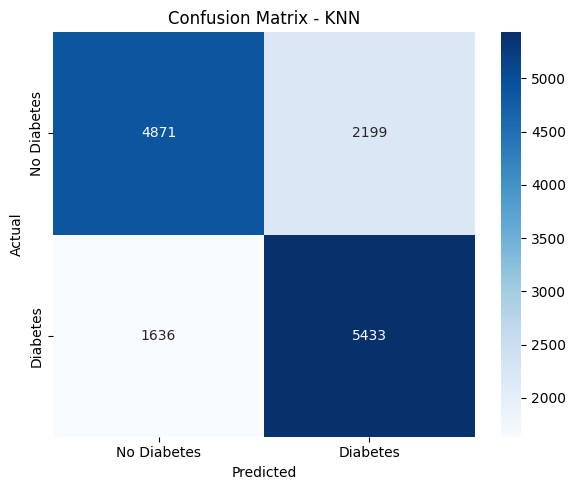

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Predict again to get y_pred
y_pred = knn.predict(X_test)

cm = confusion_matrix(y_test, y_pred)

# Plot
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["No Diabetes", "Diabetes"], yticklabels=["No Diabetes", "Diabetes"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - KNN")
plt.tight_layout()
plt.show()

/tmp/ipython-input-5-502238121.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=labels, y=metrics, palette='viridis')


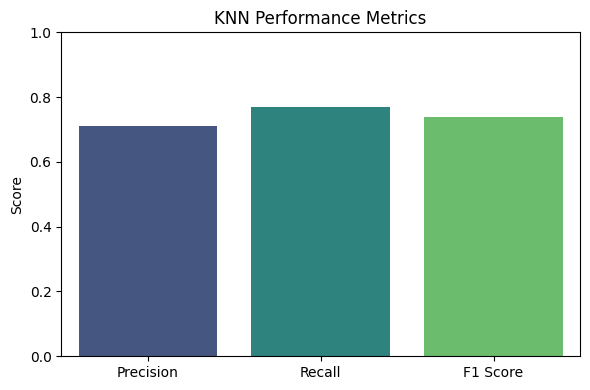

In [5]:
from sklearn.metrics import precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns

# Ensure you have predictions
y_pred = knn.predict(X_test)

# Calculate metrics
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

# Plot
plt.figure(figsize=(6, 4))
metrics = [precision, recall, f1]
labels = ['Precision', 'Recall', 'F1 Score']
sns.barplot(x=labels, y=metrics, palette='viridis')
plt.title("KNN Performance Metrics")
plt.ylim(0, 1)
plt.ylabel("Score")
plt.tight_layout()
plt.show()


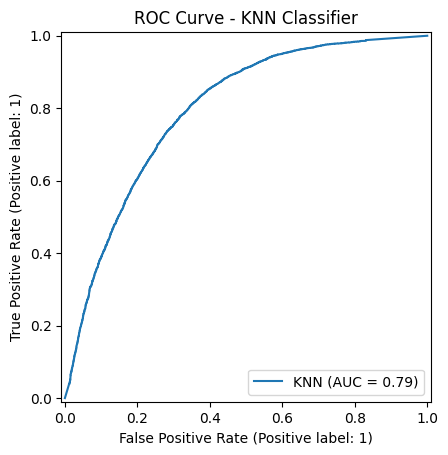

In [7]:
from sklearn.metrics import RocCurveDisplay

y_proba = knn.predict_proba(X_test)[:, 1]

RocCurveDisplay.from_predictions(y_test, y_proba, name="KNN")
plt.title("ROC Curve - KNN Classifier")
plt.show()


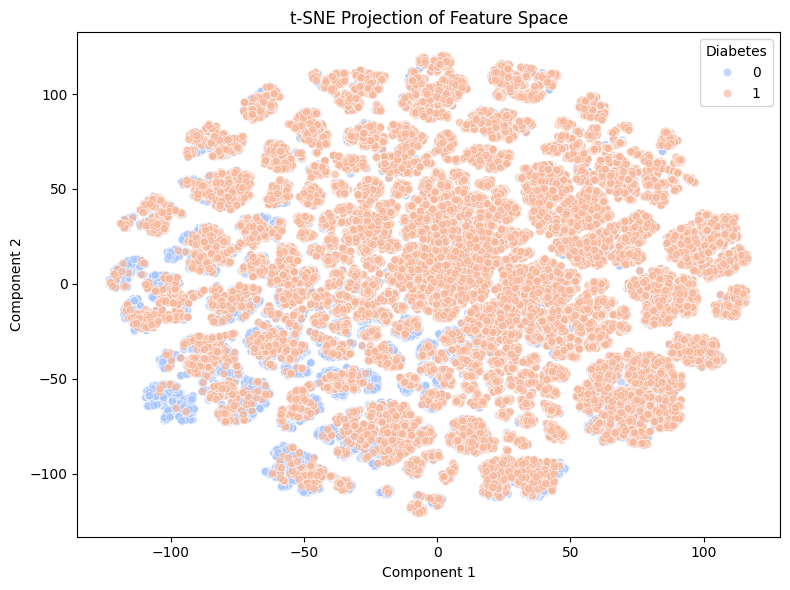

In [6]:
from sklearn.manifold import TSNE

X_scaled = StandardScaler().fit_transform(X)
X_embedded = TSNE(n_components=2, random_state=42).fit_transform(X_scaled)

plt.figure(figsize=(8, 6))
sns.scatterplot(x=X_embedded[:, 0], y=X_embedded[:, 1], hue=y, palette='coolwarm', alpha=0.7)
plt.title("t-SNE Projection of Feature Space")
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.legend(title="Diabetes")
plt.tight_layout()
plt.show()
